In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spotify Data Analysis

In [4]:
df = pd.read_csv("archive/data.csv")
df_artists = pd.read_csv("archive/data_by_artist.csv")
df_genres = pd.read_csv("archive/data_by_genres.csv")
df_year = pd.read_csv("archive/data_by_year.csv")
df_w_genres = pd.read_csv("archive/data_w_genres.csv")

In [3]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


Most of the other datasets are aggregations of this one.  The genre data is the only one that presents information that is not found in this dataset, and it provides aggregations of the data at the genre level or includes what genres an artist encapsualtes. 

The columns in this dataset mostly go over technical muscial information, more detail can be found at this link: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/



## EDA 

Problem Statement Ideas: 
* Can we extract genre from the various musical features, using an unsupervised learning technique? 
    - most likely learn genre via clustering, K-means or GMM?
* Can we project the trend of music over time using the existing time data?


In [10]:
df.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

Null value check, perhaps we aren't accounting for the way this data represents null values, i.e. empty brackets, zero values, certain text strings 

First off, how does spotify define genre? Let's take a look at how many genres they define genre in their aggregate dataset

In [9]:
unique_genres = df_genres["genres"].unique()
print(len(unique_genres))
unique_genres[:20]

2664


array(['432hz', '[]', 'a cappella', 'abstract', 'abstract beats',
       'abstract hip hop', 'accordeon', 'accordion', 'acid house',
       'acid jazz', 'acid rock', 'acid trance', 'acousmatic',
       'acoustic blues', 'acoustic pop', 'acoustic punk', 'adoracion',
       'adult standards', 'adventista', 'afghan pop'], dtype=object)

There are 2,664 genres which is a very large amount, we see that there are multiple genres that have an "acid" prefix.  Liekly we will cluster and assign our own intuitive genres to each cluster or try to reduce this genre layer down to something we could use for supervised learning. 

We also see that there is an empty value for genre indicated by '[]', so we know that null values are indicated in this dataset beyond an 'na' 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

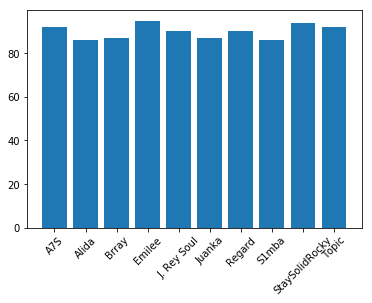

In [11]:
top10_artists = df_artist.sort_values("popularity", ascending = False).head(10)
artist = top10_artists["artists"]
artists_pop = top10_artists["popularity"]
plt.bar(artist, artists_pop)
plt.xticks(rotation= 45)

Looking to the popularity of artists in the dataset we see that the top 10 artists are relatively unknown artists (at least to us). Why could that be?

In [12]:
top10_artists

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
7176,Emilee,0.0686,0.674,176547.0,0.774,0.001880,0.3930,-7.567,0.0892,112.050,0.330,95.0,11,0,2
22417,StaySolidRocky,0.7490,0.728,147800.0,0.431,0.000000,0.0996,-9.966,0.0622,130.022,0.629,94.0,6,0,2
216,A7S,0.2230,0.789,166794.0,0.720,0.000000,0.1290,-5.652,0.2180,122.031,0.664,92.0,8,0,2
25318,Topic,0.2230,0.789,166794.0,0.720,0.000000,0.1290,-5.652,0.2180,122.031,0.664,92.0,8,0,1
19891,Regard,0.1770,0.880,157606.0,0.751,0.000064,0.1060,-4.258,0.0874,117.948,0.884,90.0,7,0,2
10612,J. Rey Soul,0.1930,0.894,249143.0,0.635,0.001050,0.0823,-6.929,0.0473,105.013,0.428,90.0,2,1,2
12348,Juanka,0.3000,0.815,345241.0,0.715,0.000005,0.0910,-4.650,0.2070,176.007,0.786,87.0,4,0,2
3353,Brray,0.3000,0.815,345241.0,0.715,0.000005,0.0910,-4.650,0.2070,176.007,0.786,87.0,4,0,1
830,Alida,0.1770,0.570,208222.0,0.672,0.000000,0.0768,-5.890,0.0723,120.019,0.448,86.0,8,0,2
20897,S1mba,0.4960,0.613,167917.0,0.624,0.000000,0.2830,-6.660,0.2060,62.948,0.804,86.0,11,0,1


We see that the count value for these artists are extremely low, so likely these artists are "one-hit wonders" or have 2 very successful songs.  Let's see how popularity measures for a universally loved artist like The Beatles

In [13]:
df_artist[df_artist["artists"] == "The Beatles"]

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
23445,The Beatles,0.360356,0.521975,174307.869988,0.546827,0.051906,0.223001,-9.682696,0.053395,121.074746,0.61966,48.060753,0,1,823


Interestingly, The Beatles have a popularity score of 48.06 compared to the above artists scores of 86-95. How does Spotify measure popularity? Let's look to the API

The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.



So likely the Beatles score is averaged over all their songs, lowering their score as there is a count of 823. It is also interesting that popularity is affected by how recent a song has been played.  Let's see how time affects popularity.

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5,1,'Popularity Over Time')

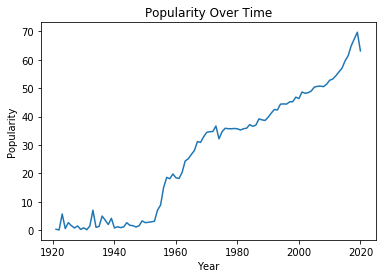

In [17]:
plt.plot(df_year['year'], df_year['popularity'])
plt.xlabel("Year")
plt.ylabel("Popularity")
plt.title("Popularity Over Time")

As we suspected popularity shows an increase over time, favoring more recent songs.  This indicates that popularity is more better defined as "current popularity".  Thus, the variable does not indicate how popular a song was when it came out, rather how popular a song was when the data was queried, roughly October, 11th 2020.  This means it may not be a reliable variable to use, or we must use it acknowleding that it is not a measure of how popular an artist or song has been historically, rather currently.

Let's look at the most popular songs in the dataset as a sanity check

In [18]:
df.sort_values("popularity", ascending = False).head(20)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
87942,0.00146,['The Weeknd'],0.514,200040,0.730,0,0VjIjW4GlUZAMYd2vXMi3b,0.000095,1,0.0897,-5.934,1,Blinding Lights,100,2020-03-20,0.0598,171.005,0.334,2020
87940,0.24700,"['DaBaby', 'Roddy Ricch']",0.746,181733,0.690,1,7ytR5pFWmSjzHJIeQkgog4,0.000000,11,0.1010,-7.956,1,ROCKSTAR (feat. Roddy Ricch),99,2020-04-17,0.1640,89.977,0.497,2020
87949,0.73100,"['Powfu', 'beabadoobee']",0.726,173333,0.431,0,7eJMfftS33KTjuF7lTsMCx,0.000000,8,0.6960,-8.765,0,death bed (coffee for your head) (feat. beabad...,97,2020-02-08,0.1350,144.026,0.348,2020
87941,0.23300,"['THE SCOTTS', 'Travis Scott', 'Kid Cudi']",0.716,165978,0.537,1,39Yp9wwQiSRIDOvrVg7mbk,0.000000,0,0.1570,-7.648,0,THE SCOTTS,96,2020-04-24,0.0514,129.979,0.280,2020
87852,0.06860,"['Surf Mesa', 'Emilee']",0.674,176547,0.774,0,62aP9fBQKYKxi7PDXwcUAS,0.001880,11,0.3930,-7.567,0,ily (i love you baby) (feat. Emilee),95,2019-11-26,0.0892,112.050,0.330,2019
87946,0.32100,['Drake'],0.834,247059,0.454,1,127QTOFJsJQp5LbJbu3A1y,0.000006,1,0.1140,-9.750,0,Toosie Slide,95,2020-04-03,0.2010,81.618,0.837,2020
87840,0.10400,['Roddy Ricch'],0.896,196653,0.586,1,0nbXyq5TXYPCO7pr3N8S4I,0.000000,10,0.7900,-6.687,0,The Box,95,2019-12-06,0.0559,116.971,0.642,2019
87844,0.30500,"['BENEE', 'Gus Dapperton']",0.863,223480,0.631,1,4nK5YrxbMGZstTLbvj6Gxw,0.000030,7,0.1230,-4.689,1,Supalonely,95,2019-11-15,0.0534,128.977,0.817,2019
87943,0.74900,['StaySolidRocky'],0.728,147800,0.431,0,5RqR4ZCCKJDcBLIn4sih9l,0.000000,6,0.0996,-9.966,0,Party Girl,94,2020-04-21,0.0622,130.022,0.629,2020
87951,0.02640,['6ix9ine'],0.611,132303,0.688,1,4NhDYoQTYCdWHTvlbGVgwo,0.000000,1,0.2510,-5.688,1,GOOBA,94,2020-05-08,0.3410,178.462,0.393,2020


These look a lot more like familiar artists. This indicates we want to stick to the song level data as opposed to data aggregated at the artist level so we do not lose detail about the data through issues like the "one-hit wonder" inflation seen above.

It seems that we will want to focus our efforts on clustering the song level data using the technical music aspects to try and discern some innate pattern that we can abstract as genre. Let's look at some of this technical music data and observe.

Text(0,0.5,'Count')

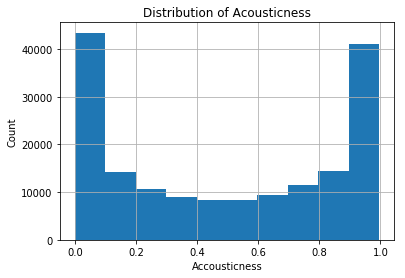

In [21]:
df["acousticness"].hist()
plt.title("Distribution of Acousticness")
plt.xlabel("Accousticness")
plt.ylabel("Count")

Text(0,0.5,'Count')

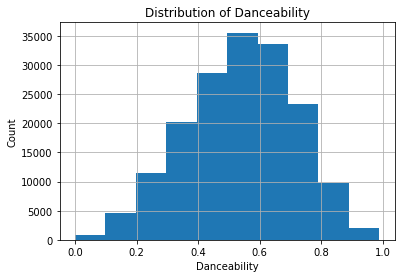

In [24]:
df["danceability"].hist()
plt.title("Distribution of Danceability")
plt.xlabel("Danceability")
plt.ylabel("Count")

We see that the spread for acousticness is heavily concentrated in the 0 and 1 bins, and Danceability is more evenly spread throughout with low concentration in the lower and upper bound bins

We'll use the genre level data to look at trends in the technical music aspects, since it helps us learn how genre behavior trends for these technical music aspects

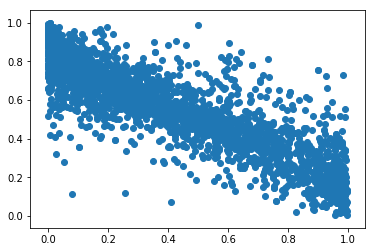

In [26]:
plt.scatter(df_genres["acousticness"], df_genres["energy"])


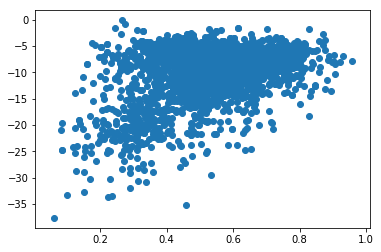

In [27]:
plt.scatter(df_genres["danceability"], df_genres["loudness"])
